# Machine Learning Engineer Nanodegree
## Deep Learning
## Capstone project: Rock-paper-scissors Classifier
### by Juan Andrés Ramírez

In this notebook is described the work done for the Udacity's Machine Learning Nanodegree capstone project

First make most of the imports:

In [1]:
from sklearn.datasets import load_files       

import numpy as np
from glob import glob
import os
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib.pyplot as plt
import cv2 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D #Conv2D, MaxPooling2D,
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from mmtc_misc_tools import plot_confusion_matrix
from PIL import Image as pil_image

from tqdm import tqdm

Using TensorFlow backend.


#### Exploring dataset
First we will start exploring the dataset and making some preprocessing. Below we load the dataset

In [2]:

#Train folder
train_folder = 'datasets/train'
validation_folder = 'datasets/validation'
test_folder = 'datasets/test'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)
valid_files, valid_targets = load_dataset(validation_folder)
test_files, test_targets = load_dataset(test_folder)

# load list of classes
class_names = [name for name in os.listdir(train_folder)]

# print statistics about the dataset
def print_dataset_stats(train_files, valid_files, test_files):
    n_total_images = len(train_files)  + len(test_files) + len(valid_files)
    print('There are %d total class categories.' % len(class_names))
    print('There are %d total images.' % n_total_images)    
    print('There are %d (%d[%%]) training images.'  % (len(train_files), len(train_files)/n_total_images*100 ))
    print('There are %d (%d[%%]) validation images.'% (len(valid_files), len(valid_files)/n_total_images*100))
    print('There are %d (%d[%%]) test images.'      % (len(test_files),  len(test_files)/n_total_images*100))
    print('Classes: ')
    for class_str in class_names:
        print(' - ' + class_str)
print_dataset_stats(train_files, valid_files, test_files)

There are 3 total class categories.
There are 1698 total images.
There are 1338 (78[%]) training images.
There are 180 (10[%]) validation images.
There are 180 (10[%]) test images.
Classes: 
 - paper
 - rock
 - scissors


Now we may see some of the training images:

Train images


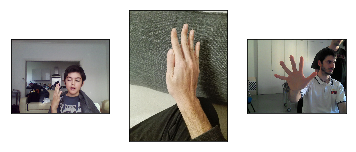

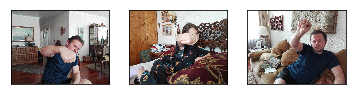

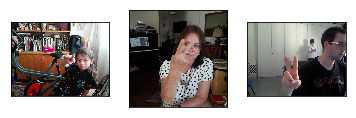

Validation images


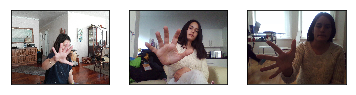

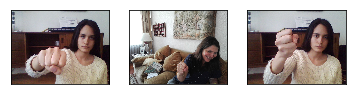

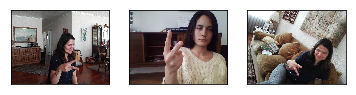

Test images


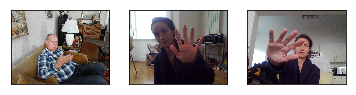

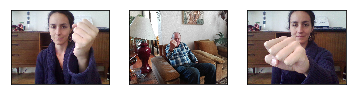

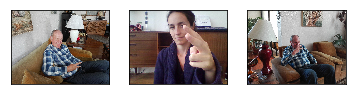

In [3]:

n_class_elements_to_show = 3

def load_image_for_show(image_path):
    img = cv2.imread(image_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

def plot_img_from_path(image_path, axes=None):
    img = load_image_for_show(image_path)
    if axes:
        axes.imshow(img)
        axes.set_xticks([])
        axes.set_yticks([])
    else:
        plt.imshow(img)

def get_int_targets(targets):
    return np.array([ np.where(r==1)[0][0] for r in targets ])

def show_images_from_set(files_list, target_int):
    for class_label in range(len(class_names)):
        class_indexes = np.nonzero(target_int==class_label)    
        f, axarr = plt.subplots(1, 3)    
        for to_show in range(n_class_elements_to_show):
            img_index = class_indexes[0][to_show]
            img_path = files_list[img_index]        
            plot_img_from_path( img_path, axarr[to_show])
    plt.show()
    
train_target_int = get_int_targets(train_targets)
valid_target_int = get_int_targets(valid_targets)
test_target_int = get_int_targets(test_targets)

print("Train images")
show_images_from_set(train_files, train_target_int)
print("Validation images")
show_images_from_set(valid_files, valid_target_int)
print("Test images")
show_images_from_set(test_files, test_target_int)

Dataset: images re-scaling and offline augmentation

In [ ]:
augmentation_factor = 5
aug_dir_train = 'dataset_aug/train'
aug_dir_valid = 'dataset_aug/valid'
#aug_dir_test = 'dataset_aug/test'

# Resize image
def resize_image(img_path):
    #Load image
    img = cv2.imread(img_path)
        
    #Preprocess
    img = cv2.resize(img, (224,224))

# Write augmented dataset to disk
def generate_augmented(files_list, targets_ints, aug_dir):    
    if not os.path.exists(aug_dir):
        os.makedirs(aug_dir)
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,        
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    for j in range(len(files_list)):#range(1):
        img_path = files_list[j]
        img =  load_img(img_path) #resize_image(img_path)
        img = img.resize((224,224)) 
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 224, 224)
        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        out_dir = aug_dir + "/" + class_names[ targets_ints[j] ]
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        i = 0
        #Copy original image
        prefix_str = 'aug-'+str(j).zfill(3)
        img.save(out_dir +'/' + prefix_str + '-a0.jpeg')
        
        #        Generate augmented images        #
        for batch in datagen.flow(x, batch_size=1,seed = 9, save_to_dir=out_dir, save_prefix=prefix_str, save_format='jpeg'):
            i += 1
            if i >= augmentation_factor-1:
                break  # otherwise the generator would loop indefinitely

#Uncomment the next lines to generate the augmented database
generate_augmented(train_files, train_target_int, aug_dir_train) 
print('Train ready')
generate_augmented(valid_files, valid_target_int, aug_dir_valid) 
print('Valid ready')
#generate_augmented(test_files, test_target_int, aug_dir_test) 
#print('Test ready')


Now we load the augmented database and get features using ResNet50

In [45]:
#aug dir definitions
main_aug_dir =  'dataset_aug'   
aug_dir_train = main_aug_dir + '/train'
aug_dir_valid = main_aug_dir + '/valid'
#aug_dir_test = main_aug_dir + '/test'
test_folder = 'datasets/test'

# load augmented train, test, and validation datasets
train_files_aug, train_targets_aug = load_dataset(aug_dir_train)
valid_files_aug, valid_targets_aug = load_dataset(aug_dir_valid)
#test_files_aug, test_targets_aug = load_dataset(aug_dir_test)
test_files, test_targets = load_dataset(test_folder)

print_dataset_stats(train_files_aug, valid_files_aug, test_files)


There are 3 total class categories.
There are 5430 total images.
There are 4890 (90[%]) training images.
There are 450 (8[%]) validation images.
There are 90 (1[%]) test images.
Classes: 
 - paper
 - rock
 - scissors


### Transfer learning approach

In [46]:
# Load ResNet50
def get_ResNet50():
    model_features_Resnet50 = ResNet50( include_top=False,
                                        weights='imagenet',
                                        input_tensor=None,
                                        input_shape=None,
                                        pooling=None)
    return model_features_Resnet50

   
def process_ResNet50(model_features_Resnet50, image_path):
    #Load image
    img = cv2.imread(image_path)
    height, width, channels = img.shape
    if height != 224 or width != 224:
        img = cv2.resize(img, (224, 224)) 
        
    #Preprocess      
    x = image.img_to_array(img)    
    img_tensor= np.expand_dims(x, axis=0)
    #Preprocess image for Resnet50
    img_preproccessed = preprocess_input(img_tensor)     
    
    #Obtain Resnet50 features    
    img_features = model_features_Resnet50.predict(img_preproccessed)
   
    return img_features

def get_features_from_db(path_list):
    model_features_Resnet50 = get_ResNet50()
    n_paths = len(path_list)
    features = []
    i = 0
    for image_path in path_list:
        features.append(process_ResNet50(model_features_Resnet50, image_path))
        if n_paths>100:
            if (i % (n_paths//10)) == 0:
                print ("Completed", i/n_paths*100, "[%]")
        i += 1
    features_array = np.concatenate(features, axis=0)
    return features_array

features_array_train = get_features_from_db(train_files_aug)
print('Train features ready')
features_array_valid = get_features_from_db(valid_files_aug)
print('Valid features ready')
features_array_test = get_features_from_db(test_files)
print('Test features ready')

#Save Features
features_ResNet50_filename = 'features/aug_resnet50.npz'
np.savez(features_ResNet50_filename, 
         train=features_array_train, 
         valid=features_array_valid, 
         test=features_array_test, 
         train_targets=train_targets_aug, 
         valid_targets=valid_targets_aug, 
         test_targets=test_targets)
         

Completed 0.0 [%]
Completed 10.0 [%]
Completed 20.0 [%]
Completed 30.0 [%]
Completed 40.0 [%]
Completed 50.0 [%]
Completed 60.0 [%]
Completed 70.0 [%]
Completed 80.0 [%]
Completed 90.0 [%]
Train features ready
Completed 0.0 [%]
Completed 10.0 [%]
Completed 20.0 [%]
Completed 30.0 [%]
Completed 40.0 [%]
Completed 50.0 [%]
Completed 60.0 [%]
Completed 70.0 [%]
Completed 80.0 [%]
Completed 90.0 [%]
Valid features ready
Test features ready


Load features

In [47]:
features_ResNet50_filename = 'features/aug_resnet50.npz'
all_features = np.load(features_ResNet50_filename)
features_array_train = all_features['train']
features_array_valid = all_features['valid']
features_array_test = all_features['test']
train_targets_aug = all_features['train_targets']
valid_targets_aug = all_features['valid_targets']
test_targets = all_features['test_targets']

Here we define the model

In [133]:
#Defining architecture.
def create_model(show_summary=False):
    the_model = Sequential()
    #print(features_array_train.shape[1:])
    the_model.add(GlobalAveragePooling2D(input_shape=features_array_train.shape[1:]) )
    the_model.add(Dense(3, activation='softmax') )
    if show_summary:
        the_model.summary()
    #compile
    the_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return the_model

model_1 = create_model(True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_25  (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 6147      
Total params: 6,147.0
Trainable params: 6,147.0
Non-trainable params: 0.0
_________________________________________________________________


In [134]:
def plot_training_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Training the model

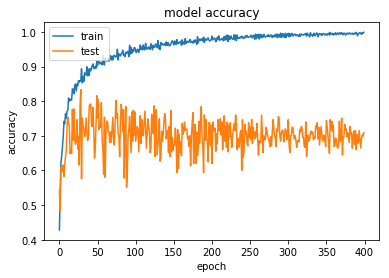

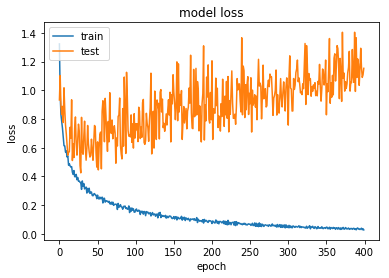

In [135]:
#Train the model.
def train_model(the_model, outfilepath, show_chart=False):
    checkpointer = ModelCheckpoint(filepath=outfilepath, 
                                   verbose=0, save_best_only=True)
    history = model_1.fit(features_array_train, 
                train_targets_aug, 
                #validation_split=0.2,
                validation_data=(features_array_valid, valid_targets_aug),
                epochs=400, batch_size=400, callbacks=[checkpointer], verbose=0,
                shuffle=True)
    if show_chart:
        plot_training_history(history)
    
train_model(model_1, 'saved_models/weights.best.model_db2.hdf5', True)

Now, we check classification over some training samples

testing_accuracy_score 0.788888888889


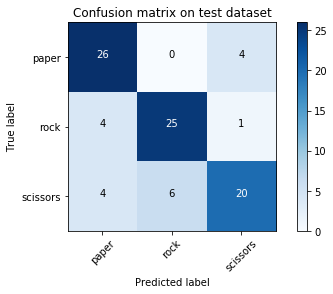

In [136]:
def classify_features(the_model, features):
    #Calc predictions
    rps_predictions = [np.argmax(the_model.predict(np.expand_dims(tensor, axis=0))) for tensor in features]
    rps_predictions_string = [class_names[class_index] for class_index in rps_predictions]
    return rps_predictions, rps_predictions_string

def classify_images(the_model, img_paths):
    paths_features = get_features_from_db(img_paths)
    return classify_features(the_model, paths_features)

#Calculate accuracy score on testing set
def calculate_testing_accuracy(test_targets_int, test_predictions):   
    testing_accuracy_score = accuracy_score(test_targets_int, test_predictions)
    return testing_accuracy_score

def make_test(the_model, saved_weights_file, showCMatrixflag=False):
    the_model.load_weights(saved_weights_file)
    test_targets_int = get_int_targets(test_targets)
    test_predictions, test_predictions_string = classify_features(the_model, features_array_test)
    testing_accuracy_score = calculate_testing_accuracy(test_targets_int, test_predictions)
    testing_cm = confusion_matrix(test_targets_int, test_predictions)    
    print ('testing_accuracy_score', testing_accuracy_score)
    if showCMatrixflag:
        plt.figure()
        plot_confusion_matrix(testing_cm, classes=class_names,
                              title='Confusion matrix on test dataset')
        plt.show()
    return testing_accuracy_score

acc_score = make_test(model_1, 'saved_models/weights.best.model_db2.hdf5', True)


Image: datasets/test\rock\WIN_20170920_16_52_02_Pro.jpg , prediction: paper


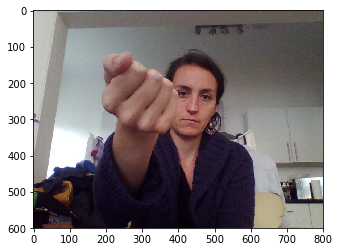

Image: datasets/test\scissors\WIN_20170920_17_00_26_Pro.jpg , prediction: rock


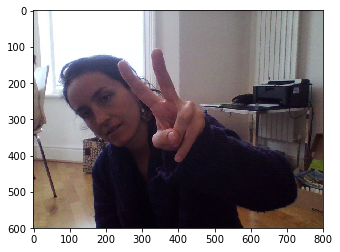

Image: datasets/test\paper\WIN_20170920_17_01_22_Pro.jpg , prediction: paper


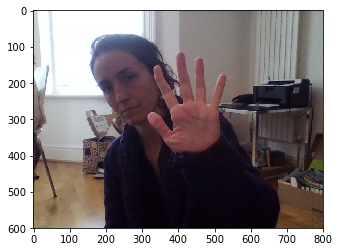

Image: datasets/test\paper\WIN_20170920_16_57_32_Pro.jpg , prediction: paper


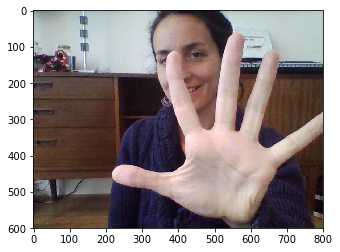

Image: datasets/test\scissors\WIN_20170920_17_00_42_Pro.jpg , prediction: scissors


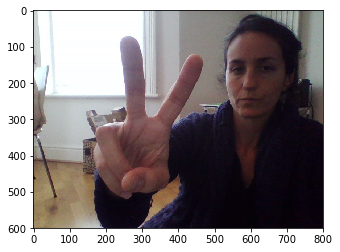

Image: datasets/test\paper\WIN_20170920_16_53_44_Pro.jpg , prediction: paper


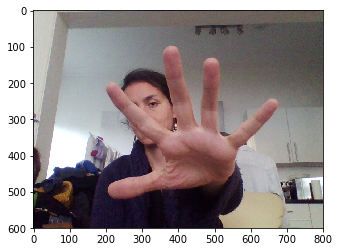

Image: datasets/test\scissors\WIN_20170920_16_52_48_Pro.jpg , prediction: scissors


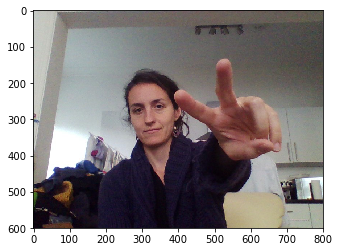

Image: datasets/test\scissors\WIN_20170920_17_00_21_Pro.jpg , prediction: scissors


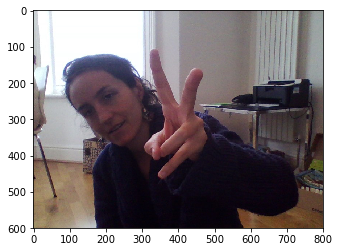

Image: datasets/test\rock\WIN_20170920_16_52_17_Pro.jpg , prediction: rock


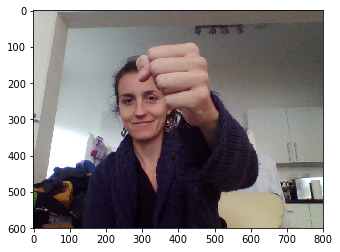

In [68]:
def show_prediction (img_path, pred_str):
    print('Image:', img_path, ', prediction:', pred_str)
    plot_img_from_path(img_path)
    plt.show()
    
def show_predictions(showing_paths, features):
    pred, pred_str = classify_features(features)
    for i in range(len(showing_paths)):
        show_prediction (showing_paths[i], pred_str[i])
    return pred, pred_str
def show_random_pred_samples(showing_paths, features):
    indexes = np.random.permutation(len(showing_paths))
    indexes = indexes[0:9]
    show_predictions(showing_paths[indexes], features[indexes])
    
show_random_pred_samples(test_files, features_array_test)

Now, we train multiple times to get a better statistic of results:

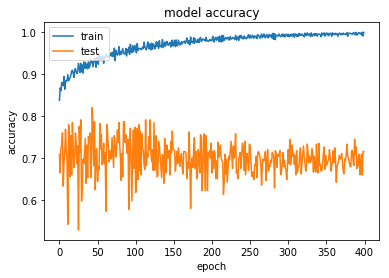

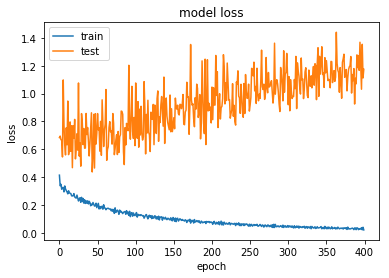

testing_accuracy_score 0.788888888889


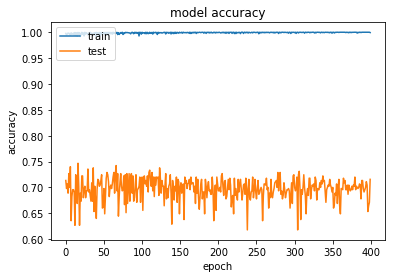

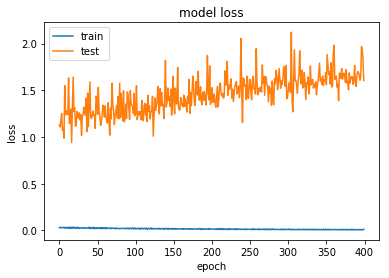

testing_accuracy_score 0.777777777778


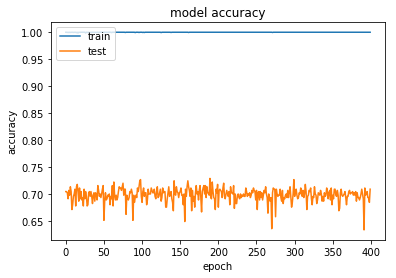

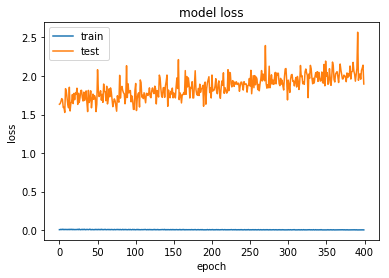

testing_accuracy_score 0.655555555556


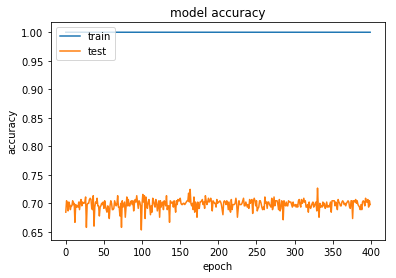

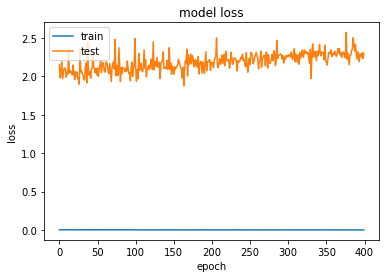

testing_accuracy_score 0.733333333333
Mean acc score is 74[%] 


In [137]:
num_train = 5
save_model_name =  'saved_models/weights.best.model_db2_stats.hdf5'
acc_score_list=[acc_score]
for k in range(0,num_train-1):
    a_model = create_model()
    train_model(a_model, save_model_name, True)
    acc = make_test(a_model, save_model_name)
    acc_score_list.append(acc)
print ("Mean acc score is %d[%%] " % (100*sum(acc_score_list)/len(acc_score_list)  ) )

### Annex: PCA features study

In this section, a brief pca study is provided

In [59]:
from sklearn.decomposition import PCA

#Get features:
#Defining architecture of a model to just extract pca features (apply globalaveragepooling to the saved features)
model_x = Sequential()
model_x.add(GlobalAveragePooling2D(input_shape=features_array_train.shape[1:]) )
model_x.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
features_pca = [model_x.predict(np.expand_dims(tensor, axis=0)).reshape(2048) for tensor in features_array_train]

# TODO: Apply PCA
pca = PCA(random_state = 0)
pca.fit(features_pca)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(features_pca)

Now we plot the explained variance ratio form the first 125 components

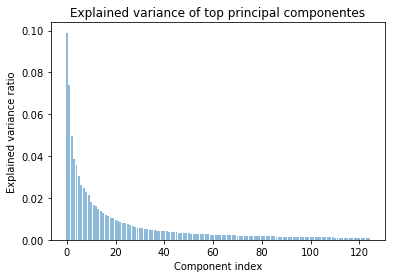

In [60]:
y_pos = np.arange(125)
plt.bar(y_pos,pca.explained_variance_ratio_[0:125], align='center', alpha=0.5)
plt.ylabel('Explained variance ratio')
plt.xlabel('Component index')
plt.title('Explained variance of top principal componentes')
plt.show()

In [104]:
print ("The first 2 components explains %d[%%] of the variance" % (np.sum(pca.explained_variance_ratio_[0:2]*100)) )
print ("The first 100 components explains %d[%%] of the variance" % (np.sum(pca.explained_variance_ratio_[0:101]*100)) )

The first 2 components explains 17[%] of the variance
The first 100 components explains 81[%] of the variance


Now we plot de projected train dataset into 2 main components:

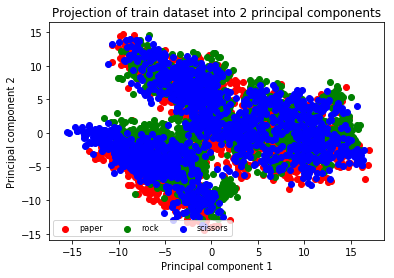

In [100]:
train_targets_int = get_int_targets(train_targets_aug)
the_colors = ['r', 'g', 'b']
series=[]
for color, i, target_name in zip(the_colors, [0, 1, 2],train_targets_int):
    si = plt.scatter(pca_samples[train_targets_int==i,1], pca_samples[train_targets_int==i,2],c=color, lw=1)
    series.append(si)

plt.legend(series, class_names,
       scatterpoints=1,
       loc='lower left',
       ncol=3,
       fontsize=8)
plt.title("Projection of train dataset into 2 principal components")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()